### Connect to google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install missingno
!pip install geopy

### read 2019 Berline Airbnb Dataset
This file already contains only 2019 data , data reduced due to its extream size


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 500)

df = pd.read_csv('/content/drive/MyDrive/kaggle/berline/Airbnb Berlin.csv')
pd.set_option('display.max_columns', None)



### Data Prepeartion

### feature selection  (round #1)
in this section we going to drop all the.
* redundant / duplicate data.
* drop all the column that contains same value , these data is not useful.
* drop columns that almost not containing any data.
* drop all the data the clearly will not help me during this jurney , like (Urls , reviewer  id , reviewer name ... )

In [4]:
df = df.drop(columns=['Review ID', 'Reviewer ID', 'Reviewer Name', 'Listing URL','Listing Name','Host ID', 'Host URL', 'Host Name',
                           'City', 'Country Code', 'Country','First Review', 'Last Review', 'Square Feet', 'Business Travel Ready',
            ])

# splite the review_date to day , month , year

In [5]:
df['review_date'] = pd.to_datetime(df['review_date'])
df['year'] = df['review_date'].dt.year
df['month'] = df['review_date'].dt.month
df['day'] = df['review_date'].dt.day


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456961 entries, 0 to 456960
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   index                 456961 non-null  int64         
 1   review_date           452805 non-null  datetime64[ns]
 2   Comments              452595 non-null  object        
 3   Listing ID            456961 non-null  int64         
 4   Host Since            456913 non-null  object        
 5   Host Response Time    398194 non-null  object        
 6   Host Response Rate    398194 non-null  object        
 7   Is Superhost          456913 non-null  object        
 8   neighbourhood         456961 non-null  object        
 9   Neighborhood Group    456961 non-null  object        
 10  Postal Code           449258 non-null  object        
 11  Latitude              456961 non-null  float64       
 12  Longitude             456961 non-null  float64       
 13 

#Replace and clean values from numbers , like $,% and more

In [7]:
# remove the $ from price
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

# remove the % from 'Host Response Rate'
df['Host Response Rate'] = df['Host Response Rate'].replace('[\%,]', '', regex=True).astype(float)

# Fix Postal Code incorrect values, remove '\n'and other irrelevant text
df['Postal Code'] = df['Postal Code'].astype(str).str[:5]

In [8]:
df.shape

(456961, 35)

# aggregate alls the reviews of Listing to one raw:
columns aggreagted on 3 deferent ways:
1. mean
2. sum
3. last value


In [10]:
# Define columns by type
rating_columns = [
      "Overall Rating","Accuracy Rating", "Cleanliness Rating", "Checkin Rating",
    "Communication Rating", "Location Rating", "Value Rating"
]

sum_columns = ["Reviews"]

categorical_columns = [
    "Host Response Time", "Neighborhood Group","neighbourhood", "Room Type"]

integer_columns = ["Bedrooms","Beds","Bathrooms","Host Response Rate","Is Superhost","Latitude","Longitude",
                         "Accomodates", "Price", "Guests Included","Min Nights","Instant Bookable",
                         "Accomodates", "year","month","day","Host Since","Is Exact Location","Postal Code"
                         ,"Latitude","Latitude"]

# Aggregation functions
aggregation_functions = {
    **{col: "mean" for col in rating_columns},  # Mean for ratings
    **{col: "sum" for col in sum_columns},      # Sum for numerical values
    **{col: 'last' for col in integer_columns},  # Concat unique values
    **{col: lambda x: ", ".join(x.dropna().unique()) for col in categorical_columns}  # Concat unique values
}

# Group by 'Listing ID' and apply aggregation
df_aggregated = df.groupby("Listing ID").agg(aggregation_functions).reset_index()

df_aggregated.head(2)

,Listing ID,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Reviews,Bedrooms,Beds,Bathrooms,Host Response Rate,Is Superhost,Latitude,Longitude,Accomodates,Price,Guests Included,Min Nights,Instant Bookable,year,month,day,Host Since,Is Exact Location,Postal Code,Host Response Time,Neighborhood Group,neighbourhood,Room Type
0,2695,100.0,10.0,10.0,10.0,10.0,9.0,10.0,49,1.0,1.0,1.0,50.0,f,52.54851,13.40455,2,17.0,1,2,f,2019.0,4.0,21.0,09-16-08,t,10437,within a day,Pankow,Prenzlauer Berg,Private room
1,3176,92.0,9.0,9.0,9.0,9.0,10.0,9.0,20736,1.0,2.0,1.0,50.0,f,52.53500,13.41758,4,90.0,2,62,f,2018.0,10.0,29.0,10-19-08,t,10405,within a day,Pankow,Prenzlauer Berg,Entire home/apt


In [11]:
df_aggregated.shape

(23536, 31)

### reduce the following wide catigories :
* Host Response Rate Grouped
* Overall Rating
* Neighbourhood Grouped
* property_types
* Postal Code

In [12]:
# Define bins and labels for 'Host Response Rate'
bins = [0, 50, 80, 95, 100]
labels = ["Low Response", "Moderate Response", "High Response", "Very High Response"]

# Apply pd.cut() to create a new binned column
df_aggregated["Host Response Rate Grouped Cleansed"] = pd.cut(df_aggregated["Host Response Rate"], bins=bins, labels=labels, include_lowest=True)

#  Reduce Categories
df_aggregated['Overall Rating Grouped Cleansed'] = df_aggregated['Overall Rating'].apply(lambda x: np.ceil(x/10))


# 2. Grouping neighbourhoods into Neighborhood Groups
# neighbourhood_mapping = df_aggregated.groupby('neighbourhood')['Neighborhood Group'].first()
# df_aggregated['Neighbourhood Grouped Cleansed'] = df_aggregated['neighbourhood'].map(neighbourhood_mapping)

# 3. Reducing Property Types
property_mapping = {
    "Villa": "Vacation Rental",
    "Cottage": "Vacation Rental",
    "Bungalow": "Vacation Rental",
    "Cabin": "Vacation Rental",
    "Tiny house": "Vacation Rental",
    "Earth house": "Vacation Rental",
    "Treehouse": "Vacation Rental",
    "Hut": "Vacation Rental",
    "Barn": "Vacation Rental",
    "Houseboat": "Boats & Houseboats",
    "Boat": "Boats & Houseboats",
    "Camper/RV": "Mobile/Alternative Lodging",
    "Cave": "Mobile/Alternative Lodging",
    "Pension (South Korea)": "Mobile/Alternative Lodging",
    "Casa particular (Cuba)": "Mobile/Alternative Lodging",
}

# Apply mapping and assign 'Other' to rare categories
top_property_types = [
    "Apartment", "Loft", "House", "Townhouse", "Condominium", "Serviced apartment",
    "Hotel", "Hostel", "Guesthouse", "Bed and breakfast", "Boutique hotel"
]

# df_aggregated['Property Type Cleansed'] = df_aggregated['Property Type'].apply(
#     lambda x: property_mapping.get(x, x) if x in top_property_types or x in property_mapping else "Other"
#)

# 4. Binning Postal Codes (first two digits represent broad area)
# df_aggregated['Postal Code Cleansed'] = df_aggregated['Postal Code'].astype(str).str[:2]  # Use only first 2 digits

### Transform data:

In [13]:
df_aggregated.shape

(23536, 33)

In [14]:
# Extracting years from date columns
df_aggregated['Host Since'] = pd.to_datetime(df_aggregated['Host Since'])
df_aggregated['Host Since Year Cleansed'] = df_aggregated['Host Since'].dt.year

#transform true/false into bool
df_aggregated['Instant Bookable Cleansed'] = df_aggregated['Instant Bookable'].replace({'t': True, 'f': False})
df_aggregated['Is Superhost Cleansed'] = df_aggregated['Is Superhost'].replace({'t': True, 'f': False})
df_aggregated['Is Exact Location Cleansed'] = df_aggregated['Is Exact Location'].replace({'t': True, 'f': False})
df_aggregated['Instant Bookable Cleansed'] = df_aggregated['Instant Bookable'].replace({'t': True, 'f': False})

In [15]:
df_aggregated.drop(columns=['Host Since', 'Postal Code',
                 'Is Exact Location',"Host Response Rate","Overall Rating","Instant Bookable","Is Superhost","Instant Bookable"
                 ], inplace=True)

In [16]:
df_aggregated.shape

(23536, 30)

### Generating new features from existing data:
Calculate the distance of each listing from Berlin's center and join each listing to a group.
Each group will contain listings that are within a specific distance from the center

In [17]:
from geopy.distance import great_circle
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

df_aggregated['Distance From Center Cleansed'] = df_aggregated.apply(lambda row: round(distance_to_mid(row['Latitude'], row['Longitude']), 1), axis=1)
bins = [0, 0.5, 1, 2, 4, 8, 16]
labels = ["Center", "Cercile1 ", "Cercile2", "Cercile4", "Cercile8", "Cercile16"]

# Apply pd.cut() to create a new binned column
df_aggregated["Distance From Center Grouped Cleansed"] = pd.cut(df_aggregated["Distance From Center Cleansed"], bins=bins, labels=labels, include_lowest=True)
df_aggregated.drop(columns=["Distance From Center Cleansed"], inplace=True)
df_aggregated.drop(columns=["Latitude","Longitude"], inplace=True)


In [18]:
df_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23536 entries, 0 to 23535
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Listing ID                             23536 non-null  int64   
 1   Accuracy Rating                        18888 non-null  float64 
 2   Cleanliness Rating                     18892 non-null  float64 
 3   Checkin Rating                         18870 non-null  float64 
 4   Communication Rating                   18886 non-null  float64 
 5   Location Rating                        18871 non-null  float64 
 6   Value Rating                           18868 non-null  float64 
 7   Reviews                                23536 non-null  int64   
 8   Bedrooms                               23516 non-null  float64 
 9   Beds                                   23501 non-null  float64 
 10  Bathrooms                              23507 non-null  flo

In [19]:
df_aggregated.to_pickle("ready_for_eda.pkl")

### cleaning data (Round: #2)
dropping the following feature , after using them to calculate new clean features.

In [ ]:
!pip install missingno
!pip install autoviz

In [29]:
df_aggregated = df_aggregated[df_aggregated["Price"] < 3000]

In [30]:
df_aggregated.shape

(23510, 29)

Shape of your Data Set loaded: (23510, 29)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  14
    Number of Integer-Categorical Columns =  4
    Number of String-Categorical Columns =  4
    Number of Factor-Categorical Columns =  2
    Number of String-Boolean Columns =  3
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    28 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['Listing ID']

################ Regression problem ##############

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Beds,float64,0.182180,NA,0.000000,22.000000,"32 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 1577 outliers greater than upper bound (3.50) or lower than lower bound(-0.50). Cap them or remove them."
Bathrooms,float64,0.159408,NA,0.000000,8.500000,"28 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 2631 outliers greater than upper bound (1.00) or lower than lower bound(1.00). Cap them or remove them."
day,float64,6.057501,NA,1.000000,31.000000,"1064 missing values. Impute them with mean, median, mode, or a constant value such as 123."
Accuracy Rating,float64,8.653572,NA,2.000000,10.000000,"1520 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 290 outliers greater than upper bound (11.50) or lower than lower bound(7.50). Cap them or remove them."
Cleanliness Rating,float64,8.630800,NA,2.000000,10.000000,"1516 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 939 outliers greater than upper bound (11.50) or lower than lower bound(7.50). Cap them or remove them."
Checkin Rating,float64,8.756049,NA,2.000000,10.000000,"1538 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 3670 outliers greater than upper bound (10.00) or lower than lower bound(10.00). Cap them or remove them."
Communication Rating,float64,8.664959,NA,2.000000,10.000000,"1522 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 3401 outliers greater than upper bound (10.00) or lower than lower bound(10.00). Cap them or remove them."
Location Rating,float64,8.750356,NA,2.000000,10.000000,"1537 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 302 outliers greater than upper bound (11.50) or lower than lower bound(7.50). Cap them or remove them."
Value Rating,float64,8.767435,NA,2.000000,10.000000,"1540 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 426 outliers greater than upper bound (11.50) or lower than lower bound(7.50). Cap them or remove them."
Bedrooms,float64,0.113863,NA,0.000000,10.000000,"20 missing values. Impute them with mean, median, mode, or a constant value such as 123., Column has 5230 outliers greater than upper bound (1.00) or lower than lower bound(1.00). Cap them or remove them."


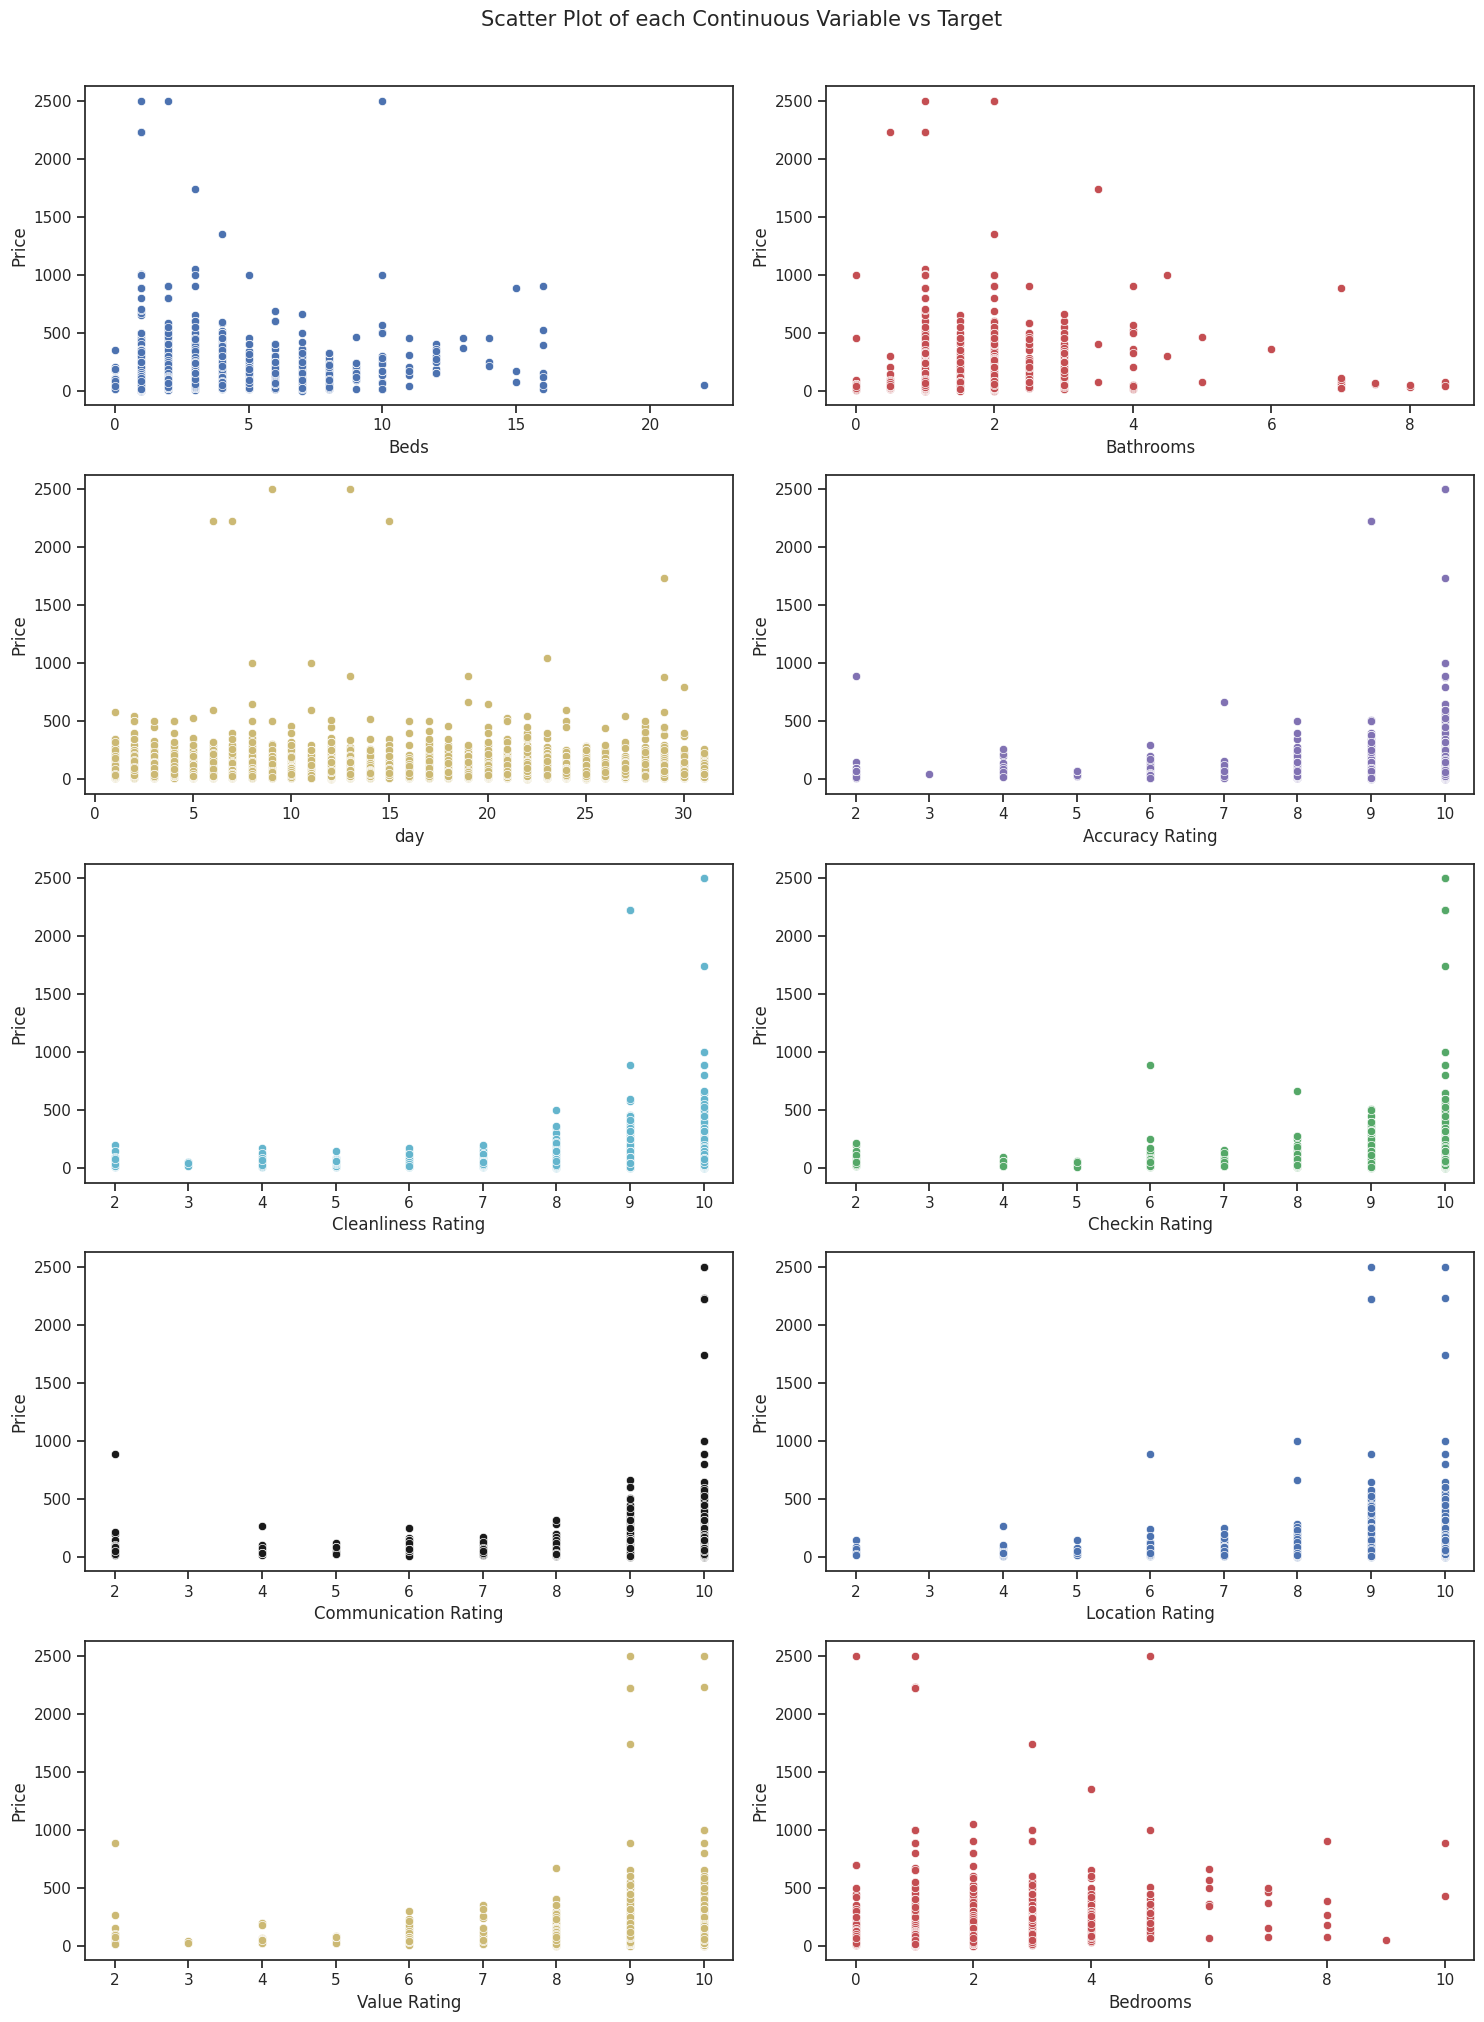

Number of All Scatter Plots = 55


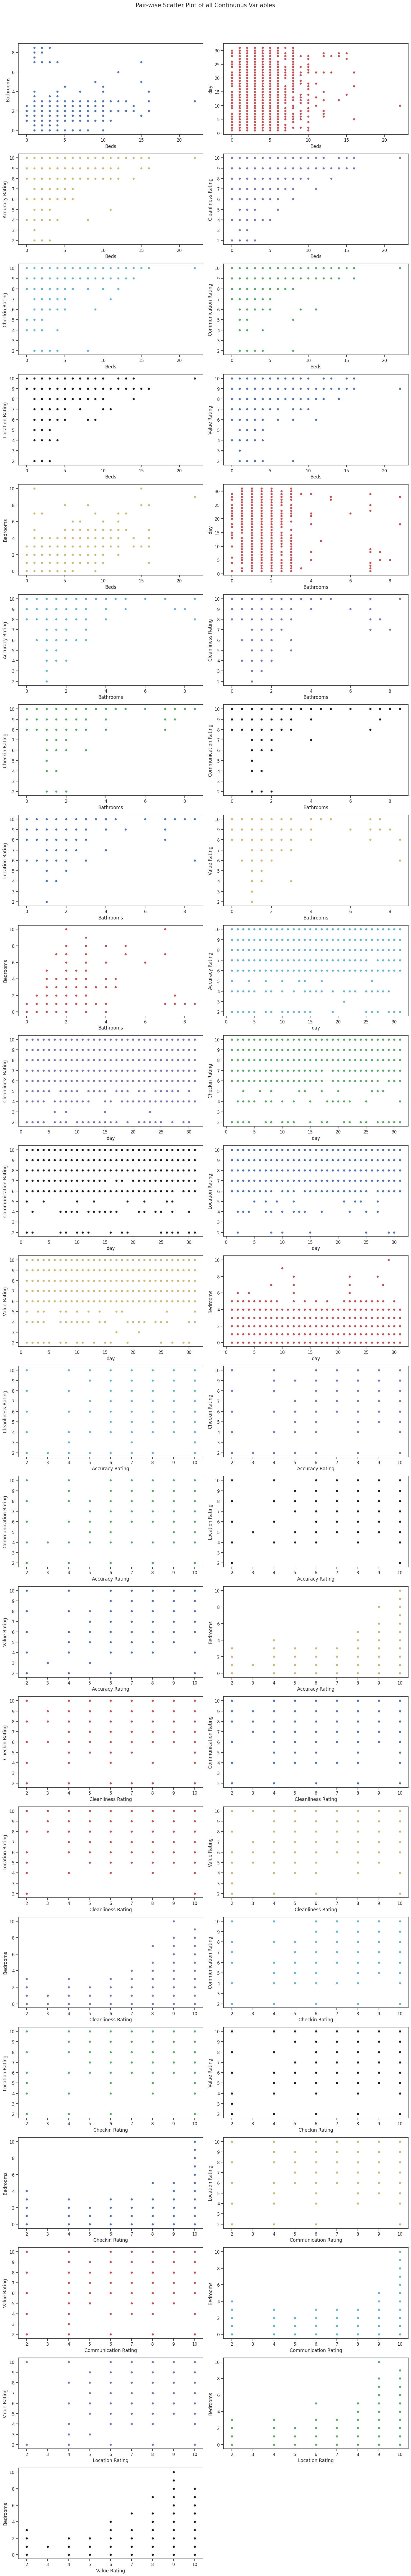

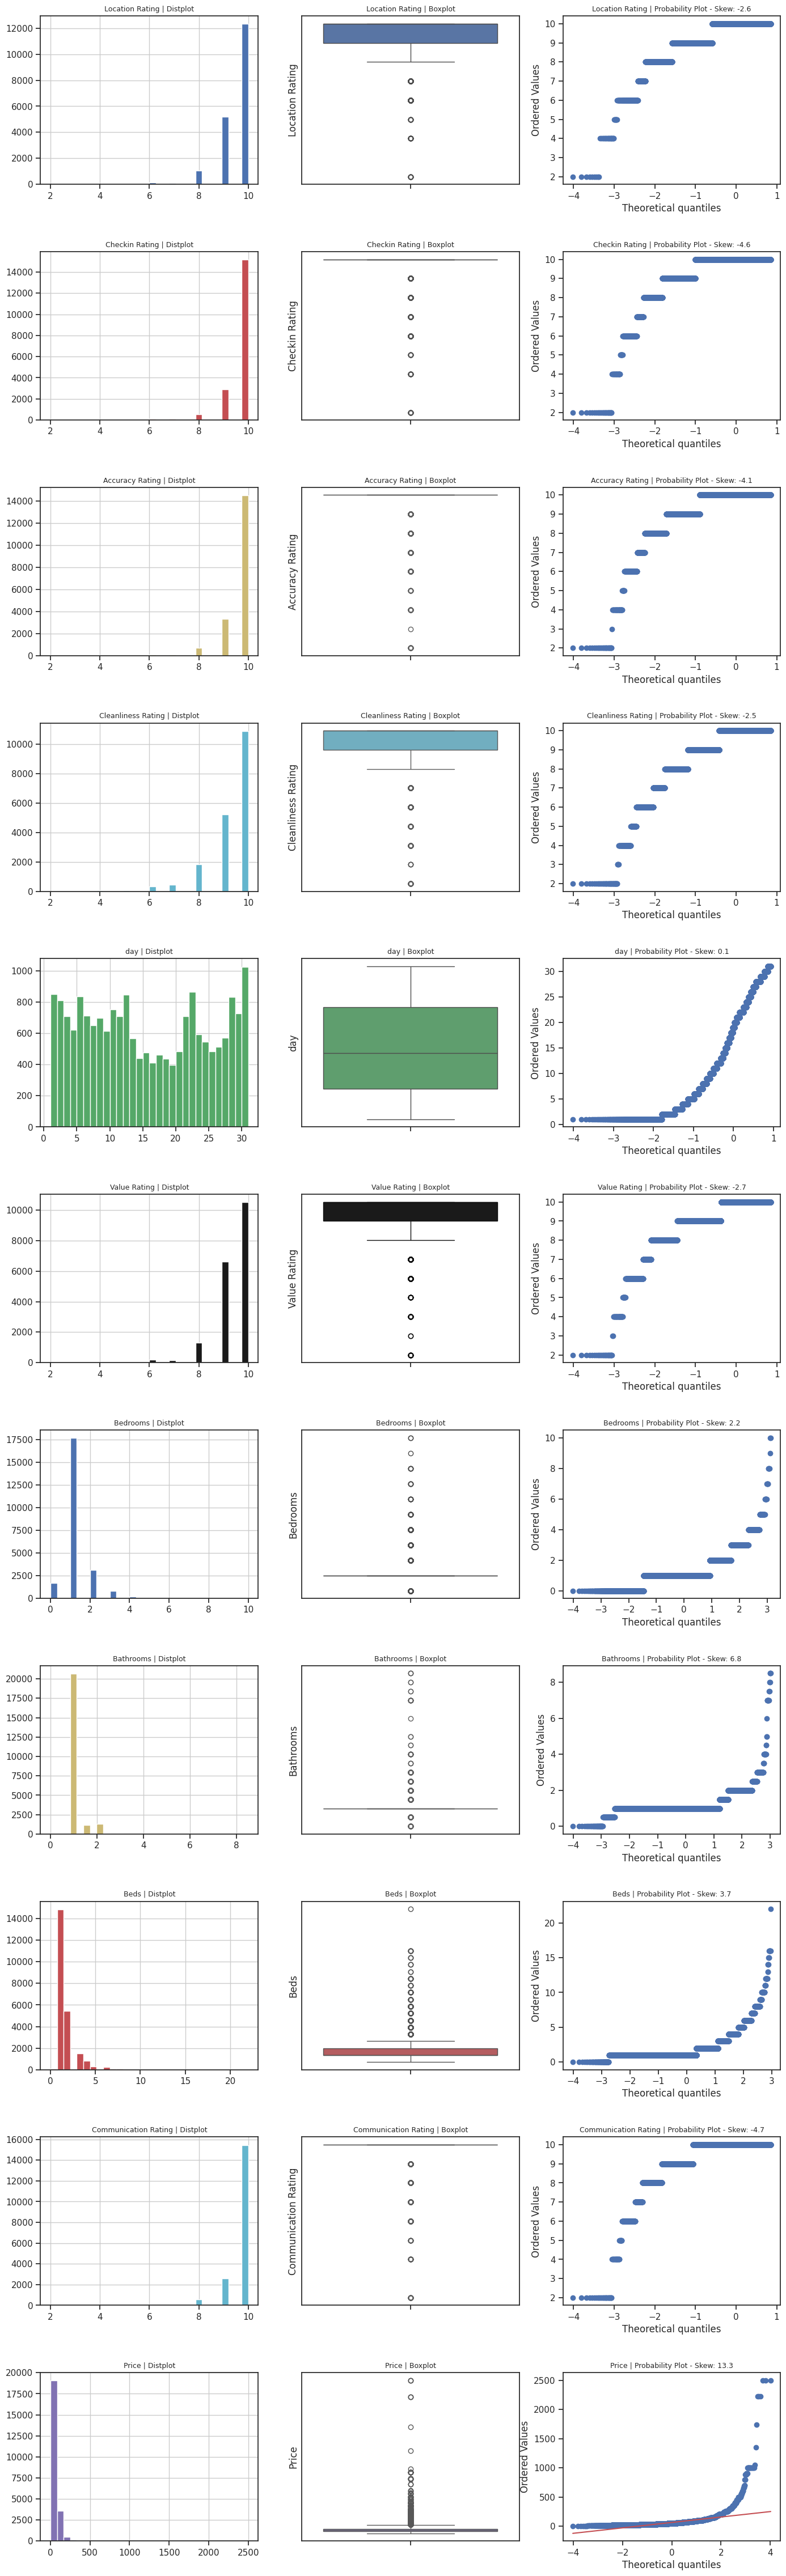

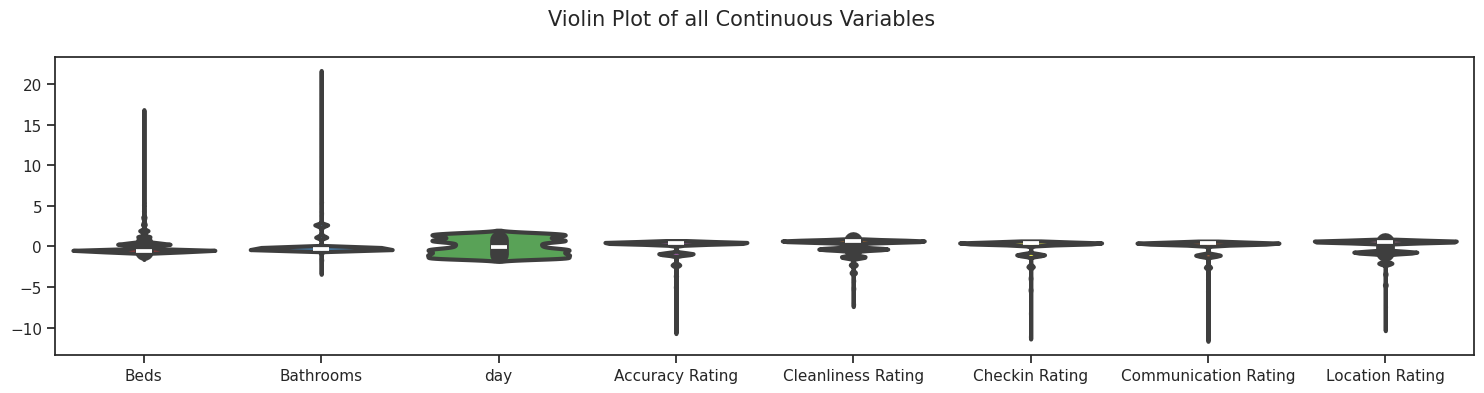

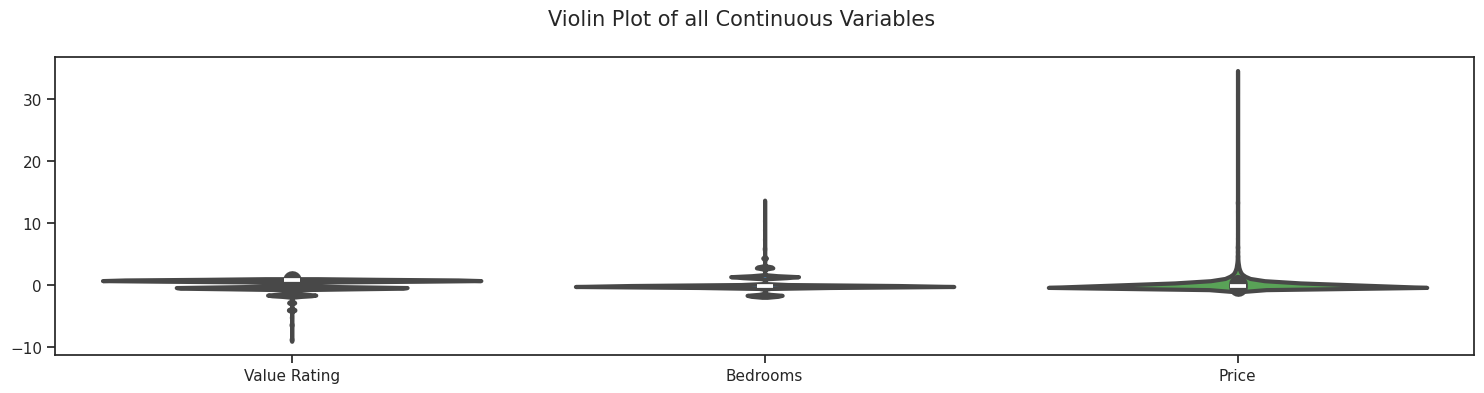

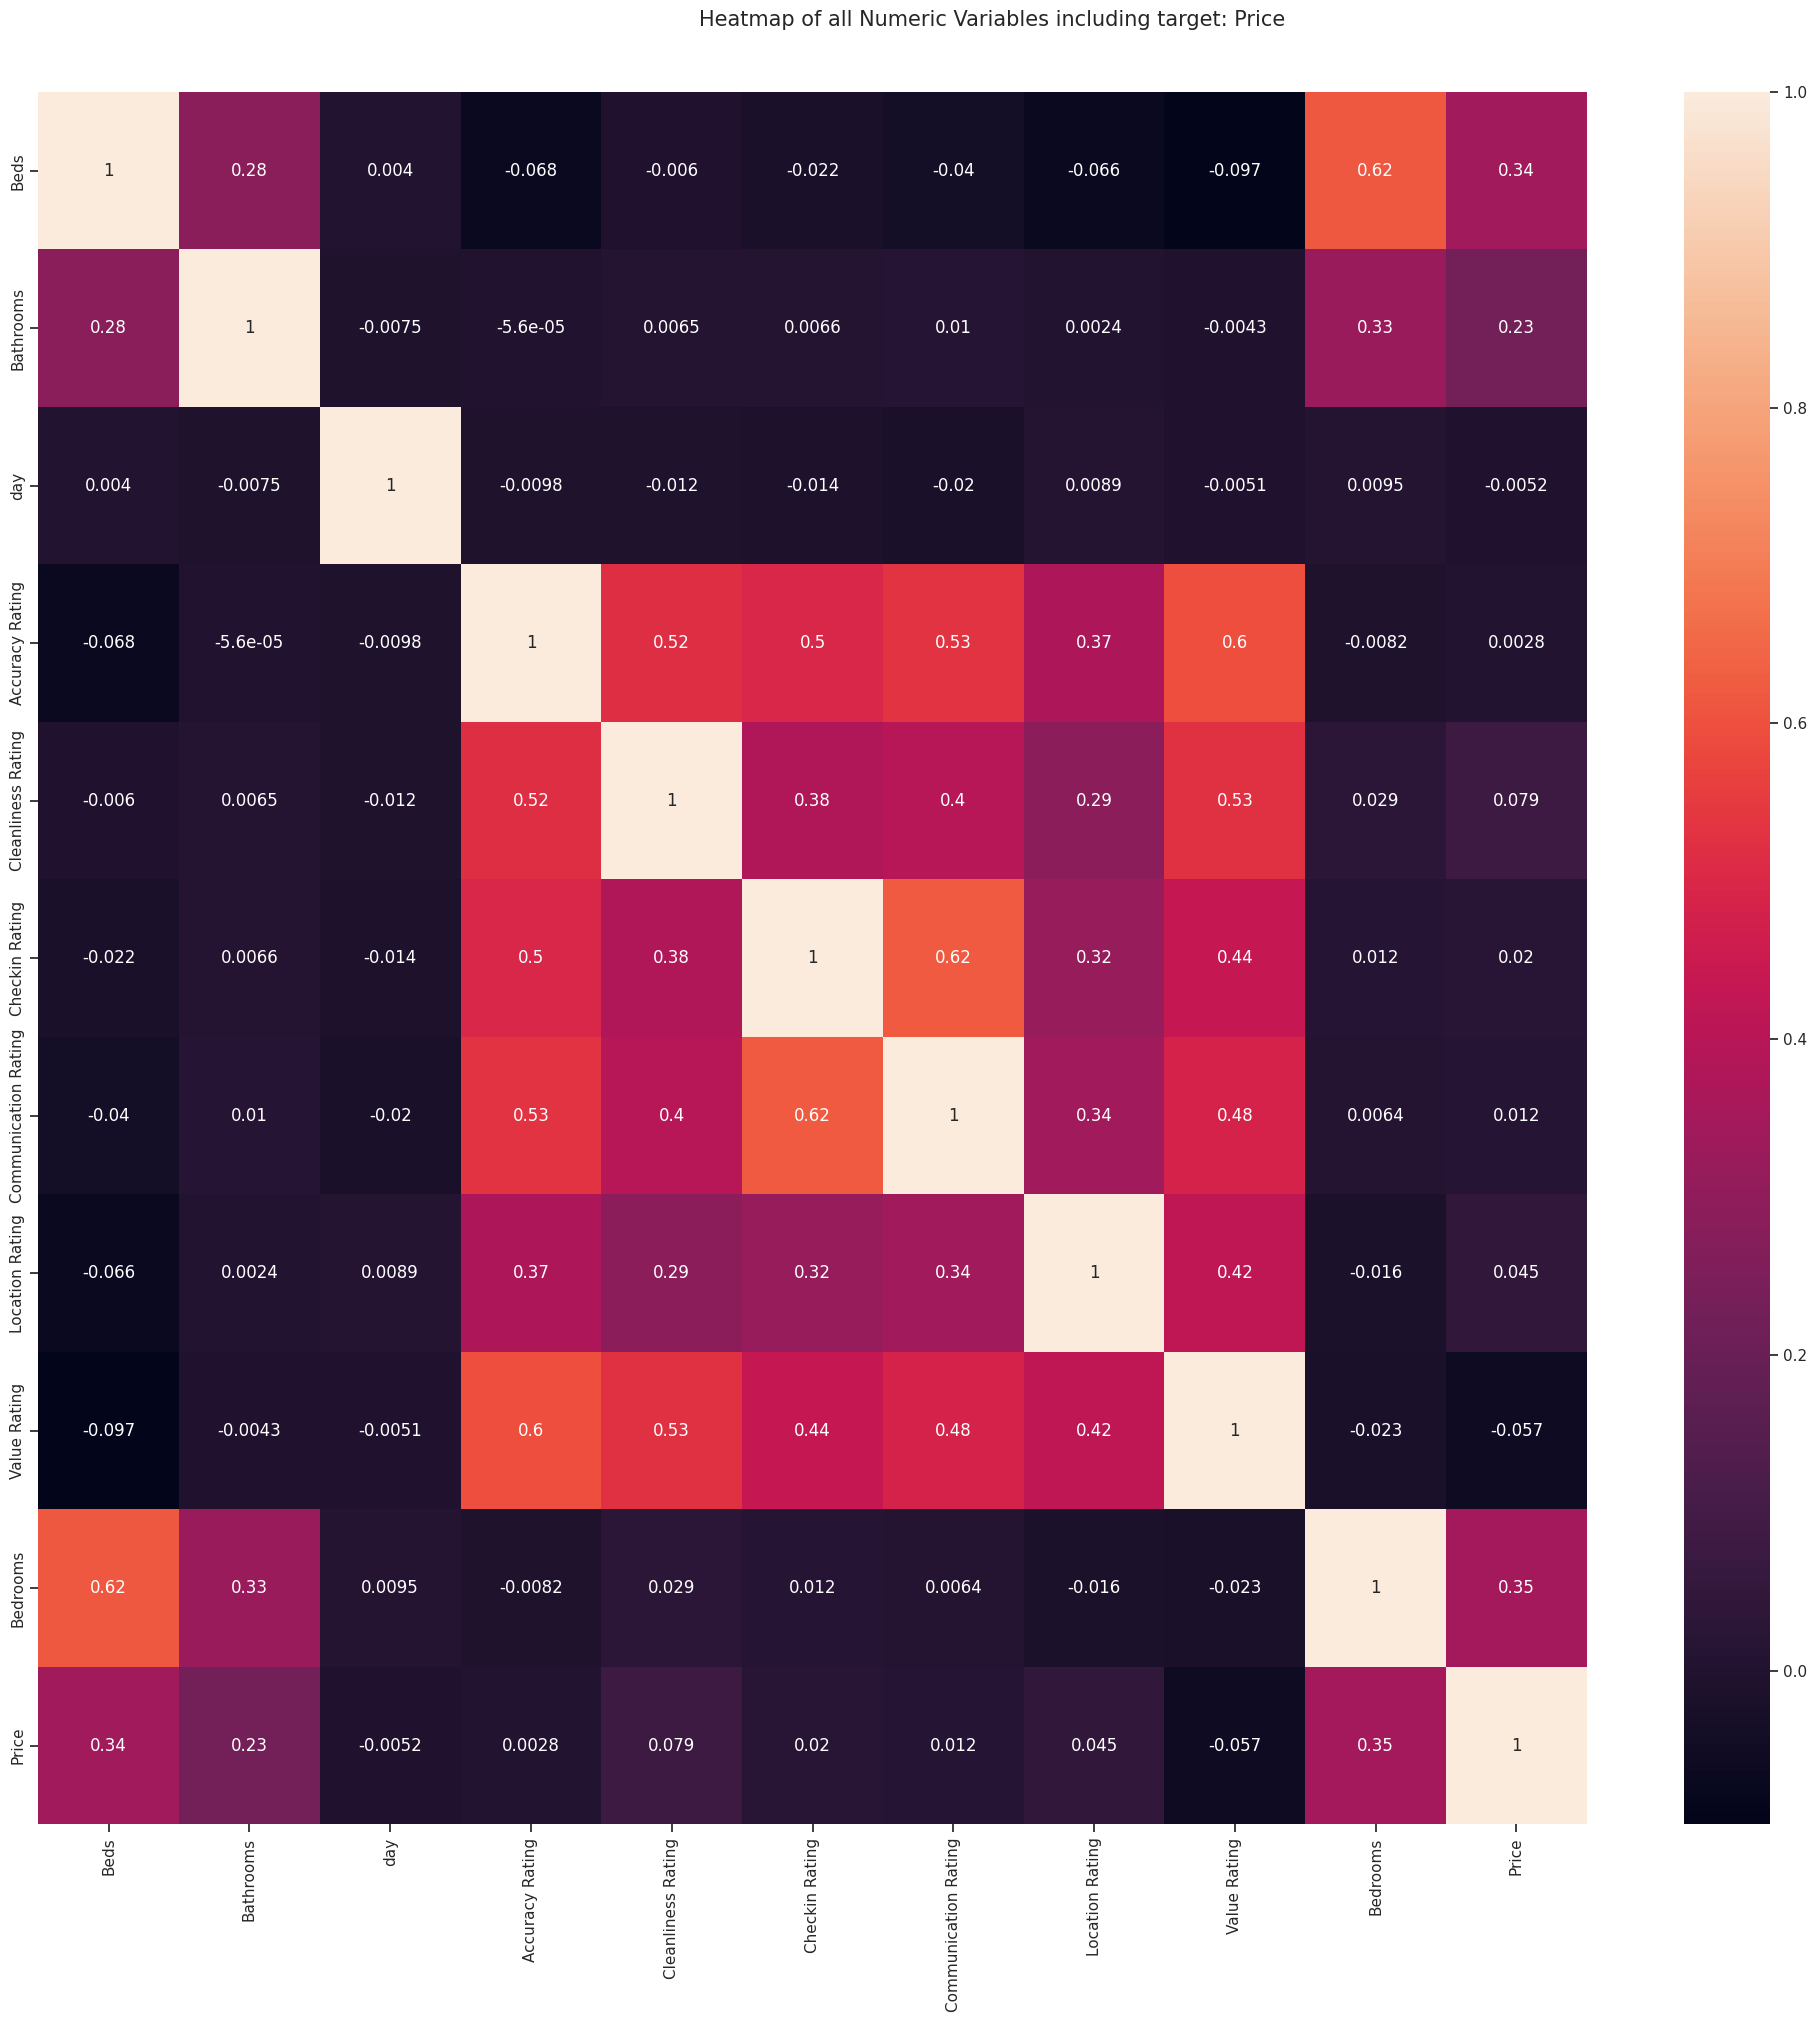

All Plots done
Time to run AutoViz = 24 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


,Beds,Bathrooms,day,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Bedrooms,Price
0,1.0,1.0,21.0,10.0,10.0,10.0,10.0,9.0,10.0,1.0,17.0
1,2.0,1.0,29.0,9.0,9.0,9.0,9.0,10.0,9.0,1.0,90.0
2,2.0,1.0,8.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,33.0
3,7.0,2.5,23.0,10.0,10.0,10.0,10.0,10.0,10.0,4.0,180.0
4,1.0,1.0,1.0,10.0,10.0,9.0,10.0,9.0,9.0,0.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...
23531,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,48.0
23532,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,30.0
23533,1.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,17.0
23534,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,52.0


In [31]:
from autoviz.AutoViz_Class import AutoViz_Class
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
AV = AutoViz_Class()

#AV = AutoViz()

# Specify the dataset and target column
# df_av = AV.AutoViz(
#     filename="",  # Leave empty if passing a DataFrame
#     df=df_aggregated,  # Your Pandas DataFrame
#     depVar="Price",  # Specify the target column
#     verbose=2
# )

AV.AutoViz(filename="", sep=",", depVar="Price", dfte=df_aggregated, max_cols_analyzed=10)


In [34]:
df_aggregated.head(5)

,Listing ID,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Reviews,Bedrooms,Beds,Bathrooms,Accomodates,Price,Guests Included,Min Nights,year,month,day,Host Response Time,Neighborhood Group,neighbourhood,Room Type,Host Response Rate Grouped Cleansed,Overall Rating Grouped Cleansed,Host Since Year Cleansed,Instant Bookable Cleansed,Is Superhost Cleansed,Is Exact Location Cleansed,Distance From Center Grouped Cleansed
0,2695,10.0,10.0,10.0,10.0,9.0,10.0,49,1.0,1.0,1.0,2,17.0,1,2,2019.0,4.0,21.0,within a day,Pankow,Prenzlauer Berg,Private room,Low Response,10.0,2008.0,False,False,True,Cercile8
1,3176,9.0,9.0,9.0,9.0,10.0,9.0,20736,1.0,2.0,1.0,4,90.0,2,62,2018.0,10.0,29.0,within a day,Pankow,Prenzlauer Berg,Entire home/apt,Low Response,10.0,2008.0,False,False,True,Cercile4
2,7071,10.0,10.0,10.0,10.0,10.0,10.0,52441,1.0,2.0,1.0,2,33.0,1,2,2019.0,5.0,8.0,within an hour,Pankow,Prenzlauer Berg,Private room,Very High Response,10.0,2009.0,False,True,True,Cercile8
3,9991,10.0,10.0,10.0,10.0,10.0,10.0,36,4.0,7.0,2.5,7,180.0,5,6,2018.0,7.0,23.0,within a day,Pankow,Prenzlauer Berg,Entire home/apt,Very High Response,10.0,2009.0,False,False,False,Cercile4
4,14325,10.0,10.0,9.0,10.0,9.0,9.0,529,0.0,1.0,1.0,1,70.0,1,90,2018.0,11.0,1.0,within a day,Pankow,Prenzlauer Berg,Entire home/apt,Very High Response,10.0,2009.0,False,False,True,Cercile8


In [69]:
new_df=['Accuracy Rating','Cleanliness Rating', 'Checkin Rating','Communication Rating','Location Rating','Value Rating', 'Bedrooms','Accomodates','Beds']
df_cat= df_aggregated[new_df]

a=3 #number of rows
b=3 #number of columns
c=1 #plot counter

fig=plt.figure(figsize=(50,40))
plt.subplots_adjust(hspace = 0.8)
sns.set(font_scale = 2)
for i in df_cat:

    plt.subplot(a,b,c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    sns.countplot(df_cat[i])
    c=c+1

plt.show()

# fig=plt.figure(figsize=(50,40))
# plt.subplots_adjust(hspace = 0.8)
# sns.set(font_scale = 2)
# for i in df_cat:
#   fig, ax=plt.subplots(figsize=(20, 5))
#   sns.countplot(x=df_aggregated[i].dropna(),data=df_aggregated,ax=ax)
# plt.show()

KeyboardInterrupt: 